# Train a recurrent neural network to predict the position of the mouse in the v0,v1 coordinate system.

We train a model for each recording session.

We get the animal position in the v0,v1 coordinate system from `transform_xy_to_grid_representation()`.

We get the instantaneous firing rate of all our grid cells. 

We need to remove time-points with invalid values as the model can't deal with np.nan.


### Rate normalization

The firing rate of neuron is normalize for two reasons: all neurons have a similar contribution and values around 0 should facilitate learning. For each neuron, the rate vector is transform so that its mean is 0 and STD is 1. 

When doing inference, we will use the same transformation as during training to normalize the firing rate. This is because we often have a very poor estimate of the firing rate from short streches of data used for inference.

### v0,v1 as model labels

Each component of v0,v1 coordinate is periodic (circular data). To facilite learning, We decompose $v_{i}$ into $cos(v_{i})$ and $sin(v_{i})$. This way the values will range from -1 to 1 and the jumps from 360 to 0 degrees are avoided. You can think of $v_{i}$ as a circle with a radius of 1.

### Trained model

The trained model is saved in `session_name.grid_cell_rnn_model.pt` in each session directory.

In [75]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Spike_train import Spike_train
from spikeA.Animal_pose import Animal_pose
from spikeA.Spatial_properties import Spatial_properties
from spikeA.Neuron import Simulated_place_cell, Simulated_grid_cell
from scipy.stats import multivariate_normal
from scipy.stats import poisson
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import stats
from scipy import ndimage
from scipy.stats import wilcoxon, pearsonr
from scipy.signal import find_peaks
import torch
import numpy as np
import datetime

from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Break down of what goes into the model

<li>Input: Firing rate of many different grid cells as a function of time, split into sequences of 20 consequetive spike trains</li>
<li>Label: Location of the animal at that time point in toroidal coordinates</li>
<li>We first generate the training dataset, which uses animal position in the first random foraging</li>

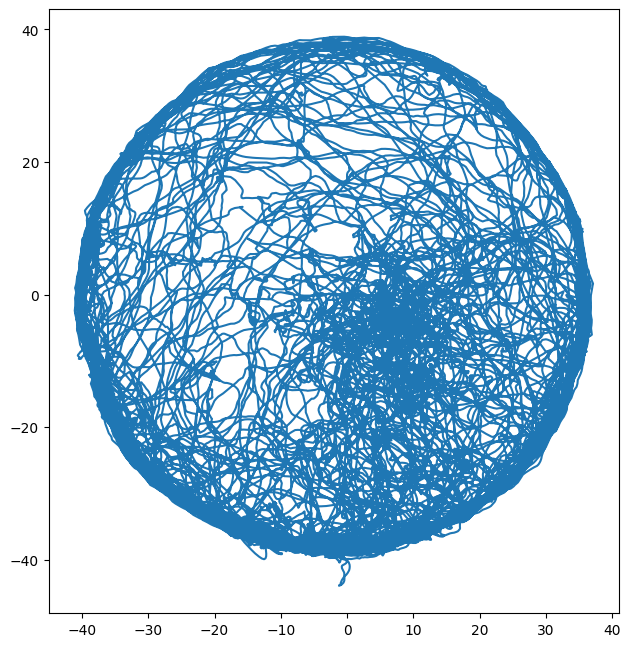

In [76]:
# Visualization of the first RF
ap = Animal_pose()
ap.load_pose_from_file(file_name=firstRF)

fig, ax = plt.subplots(figsize=(8,8))

ax.plot(ap.pose[:,1],ap.pose[:,2])
ax.set_aspect('equal') 

In [77]:
# Generate the simultaneously created grid cells
grid_param = {}
grid_param["n_cells"] = 25
grid_param["orientation"] = np.array([0,np.pi/3,np.pi/3*2])
grid_spacing = 35
grid_param["period"] = np.array([grid_spacing*np.cos(np.pi/6),grid_spacing*np.cos(np.pi/6),grid_spacing*np.cos(np.pi/6)])
grid_param["offset"] = np.random.rand(grid_param["n_cells"],2)*grid_param["period"][0]
peak_rates = np.random.normal(loc=15.0, scale=10.0, size=grid_param["n_cells"] )
peak_rates[peak_rates<5] = 5
grid_param["peak_rate"] = peak_rates

neuron_list = [Simulated_grid_cell(name=f"{i}", 
                                   offset=grid_param["offset"][i,:],
                                   orientation=grid_param["orientation"],
                                   period=grid_param["period"], 
                                   peak_rate=grid_param["peak_rate"][i], ap=ap)  for i in tqdm(range(grid_param["n_cells"]))]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:42<00:00,  1.71s/it]


In [78]:
for n in neuron_list:
    n.spatial_properties.firing_rate_map_2d()

In [79]:
train_pose = np.stack([ap.pose[:,0],ap.pose[:,1],ap.pose[:,2],ap.pose[:,4]]).T # only consider the data that we will be using
train_pose.shape

(87407, 4)

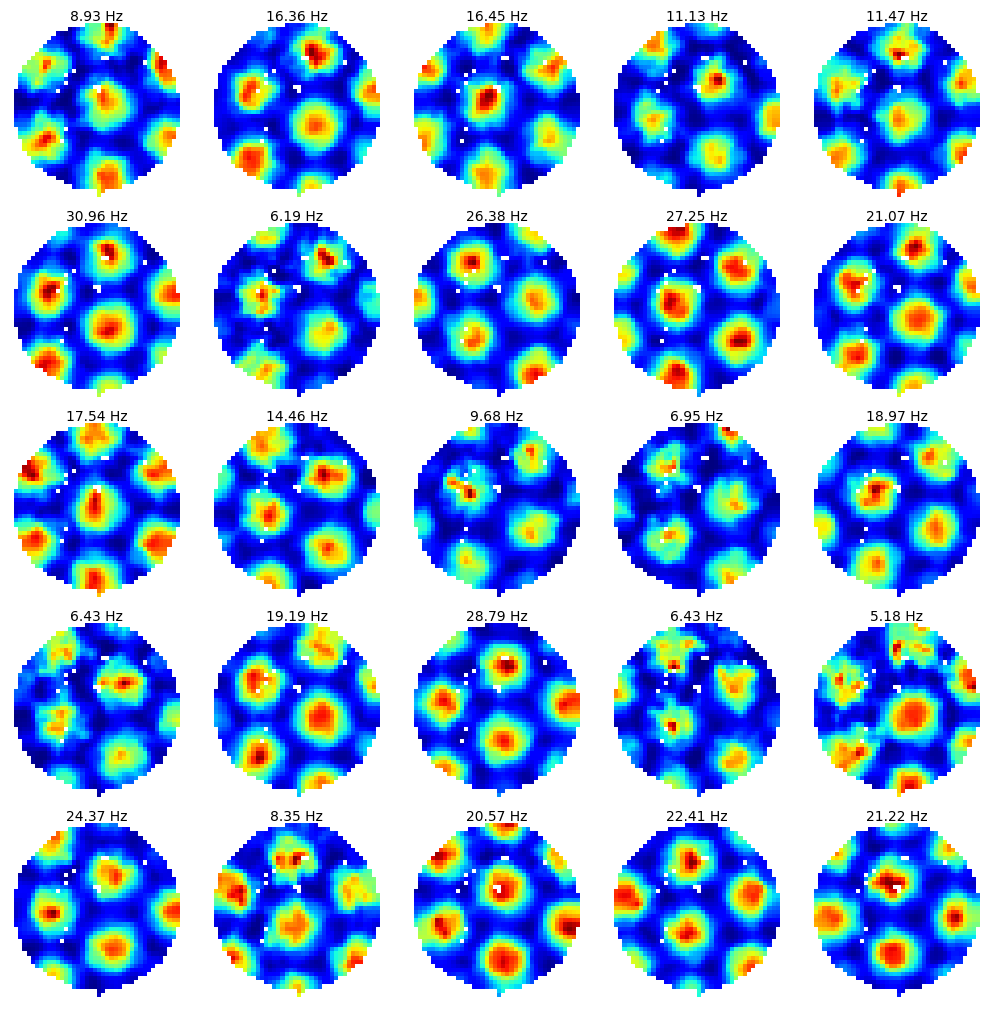

In [80]:
rowSize,colSize= 2,2
ncols=5
nrows=int(np.ceil(len(neuron_list)/ncols))
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)


for i, n in enumerate(neuron_list):
    x = int(i/ncols)
    y = i%ncols
    ax = fig.add_subplot(mainSpec[x,y])
    plotMap(ax,n.spatial_properties.firing_rate_map,title = "{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)))

In [81]:
# Get the grid cell IFR during training
ifrList = []
for i, n in tqdm(enumerate(neuron_list)):

    n.spike_train.instantaneous_firing_rate(bin_size_sec=0.02,sigma=2,shift_start_time =0.01)
    ifrList.append(n.spike_train.ifr[0])    
    if(i == 0):
        time = n.spike_train.ifr[2]
    n.spike_train.ifr=None # remove the reference to the numpy array, which can be deleted by garbage collector

ifr,time = (np.stack(ifrList,axis=0),time.round(4)) # added the round so that the numbers are not 0.019999999 but 0.02
train_ifr = ifr.T
train_time = time

25it [00:00, 309.17it/s]


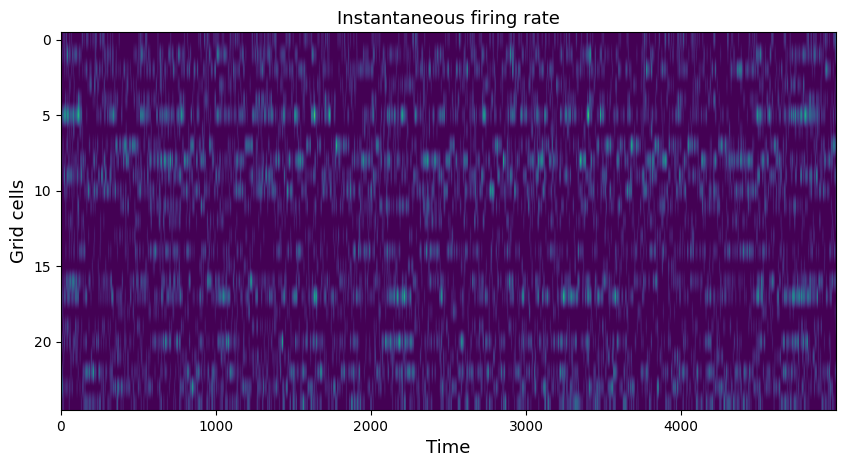

In [82]:
# Visualize the spike_train
fig, ax =plt.subplots(figsize=(10,5))
ax.imshow(train_ifr[:5000,:].T,aspect="auto",interpolation=None)
ax.set_xlabel('Time',fontsize=13)
ax.set_ylabel('Grid cells',fontsize=13)
ax.set_title('Instantaneous firing rate',fontsize=13)

fig.savefig('../img/notebook4_grid_cell_ifr.png', dpi=300, bbox_inches='tight')


In [83]:
train_ifr.shape,train_time.shape,train_pose.shape

((87407, 25), (87407,), (87407, 4))

<li>Training is performed in the first random foraging, using 80% percent of data for training and 20% for testing.</li> <br>
<li>For the validation cohort, we use the second random foraging position data.</li>

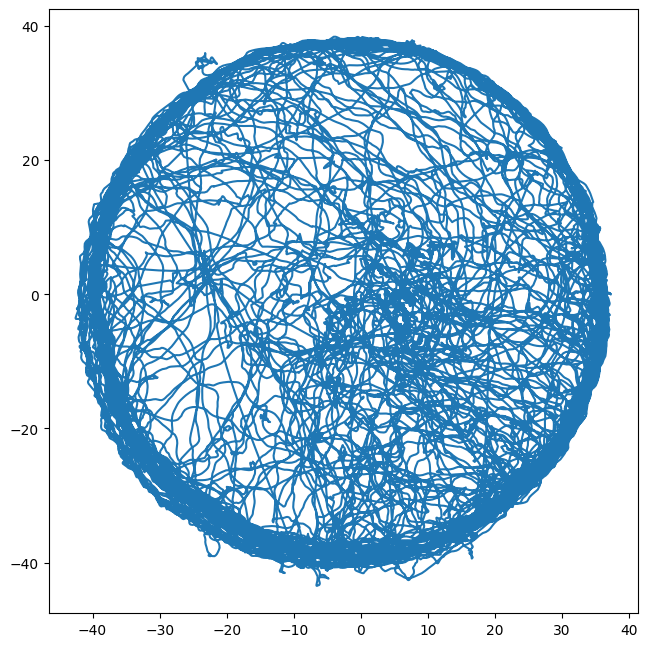

In [84]:
# Visualize animal position in the last random foraging
lap = Animal_pose()
lap.load_pose_from_file(file_name=lastRF)

fig, ax = plt.subplots(figsize=(8,8))

ax.plot(lap.pose[:,1],lap.pose[:,2])
ax.set_aspect('equal') 

In [85]:
# Generate the test neuron list using simulated grid cells
# This neuron list uses position data from the second random foraging data

test_neuron_list = [Simulated_grid_cell(name=f"{i}", 
                                   offset=grid_param["offset"][i,:],
                                   orientation=grid_param["orientation"],
                                   period=grid_param["period"], 
                                   peak_rate=grid_param["peak_rate"][i], ap=lap)  for i in tqdm(range(grid_param["n_cells"]))]

100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


In [86]:
for n in test_neuron_list:
    n.spatial_properties.firing_rate_map_2d()

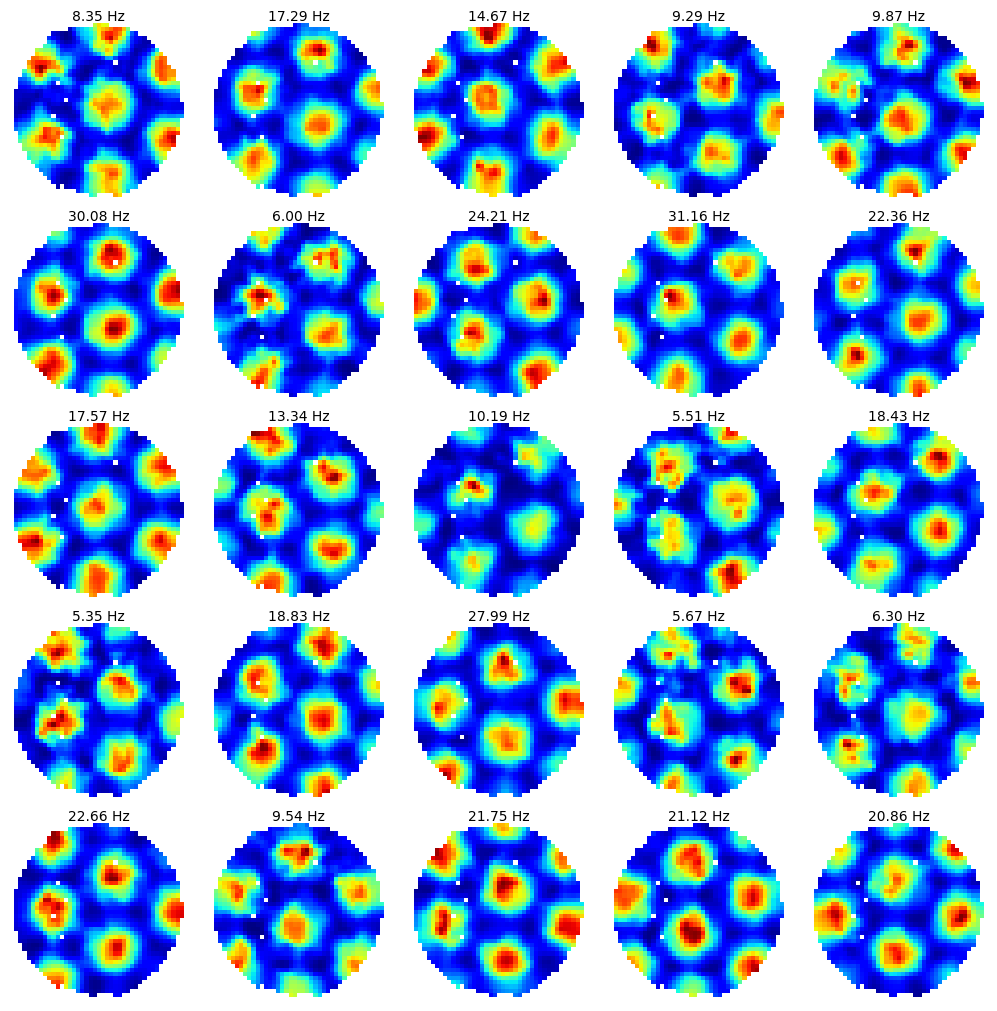

In [87]:
rowSize,colSize= 2,2
ncols=5
nrows=int(np.ceil(len(neuron_list)/ncols))
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)


for i, n in enumerate(test_neuron_list):
    x = int(i/ncols)
    y = i%ncols
    ax = fig.add_subplot(mainSpec[x,y])
    plotMap(ax,n.spatial_properties.firing_rate_map,title = "{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)))

In [88]:
test_pose = np.stack([lap.pose[:,0],lap.pose[:,1],lap.pose[:,2],lap.pose[:,4]]).T # only consider the data that we will be using
test_pose.shape

(87750, 4)

In [89]:
ifrList = []
for i, n in tqdm(enumerate(test_neuron_list)):

    n.spike_train.instantaneous_firing_rate(bin_size_sec=0.02,sigma=2,shift_start_time =0.01)
    ifrList.append(n.spike_train.ifr[0])    
    if(i == 0):
        time = n.spike_train.ifr[2]
    n.spike_train.ifr=None 

ifr,time = (np.stack(ifrList,axis=0),time.round(4)) # added the round so that the numbers are not 0.019999999 but 0.02
test_ifr = ifr.T
test_time = time

0it [00:00, ?it/s]

25it [00:00, 318.17it/s]


In [90]:
test_ifr.shape,time.shape,test_pose.shape

((87750, 25), (87750,), (87750, 4))

# Save the ifr, pose and grid parameters

In [91]:
if train_ifr.shape[0] != train_pose.shape[0]:
    print("Problem with the shape of ifr and pose")
    print(train_ifr.shape,train_pose.shape)
print(train_ifr.shape)

(87407, 25)


In [92]:
if test_ifr.shape[0] != test_pose.shape[0]:
    print("Problem with the shape of ifr and pose")
    print(test_ifr.shape,test_pose.shape)
print(test_ifr.shape)

(87750, 25)


In [93]:
fn = "../data/train_ifr.pkl"
pickle.dump((train_ifr,train_time),open(fn,"wb"))

fn = "../data/test_ifr.pkl"
pickle.dump((test_ifr,test_time),open(fn,"wb"))

In [94]:
train_pose.shape, test_pose.shape

((87407, 4), (87750, 4))

In [95]:
fn = "../data/train_pose.pkl"
pickle.dump(train_pose,open(fn,"wb"))

fn = "../data/test_pose.pkl"
pickle.dump(test_pose,open(fn,"wb"))

In [96]:
# The grid parameters will be inferred using function from Step 2

(37.28862755763791, 0.5500431582042735, 5.105213546402975, array([[45.0962094 , 56.99722046],
       [34.17134673, 62.92519675],
       [23.57513733, 56.42797629],
       [23.9037906 , 44.00277954],
       [34.82865327, 38.07480325],
       [45.42486267, 44.57202371],
       [45.0962094 , 56.99722046]]))
Firing rate maps used to find grid cell parameters


  0%|          | 0/25 [00:00<?, ?it/s]

{'period': array([33.01308399, 33.01308399, 33.01308399]), 'offset': array([31, 18]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.0350262781047501


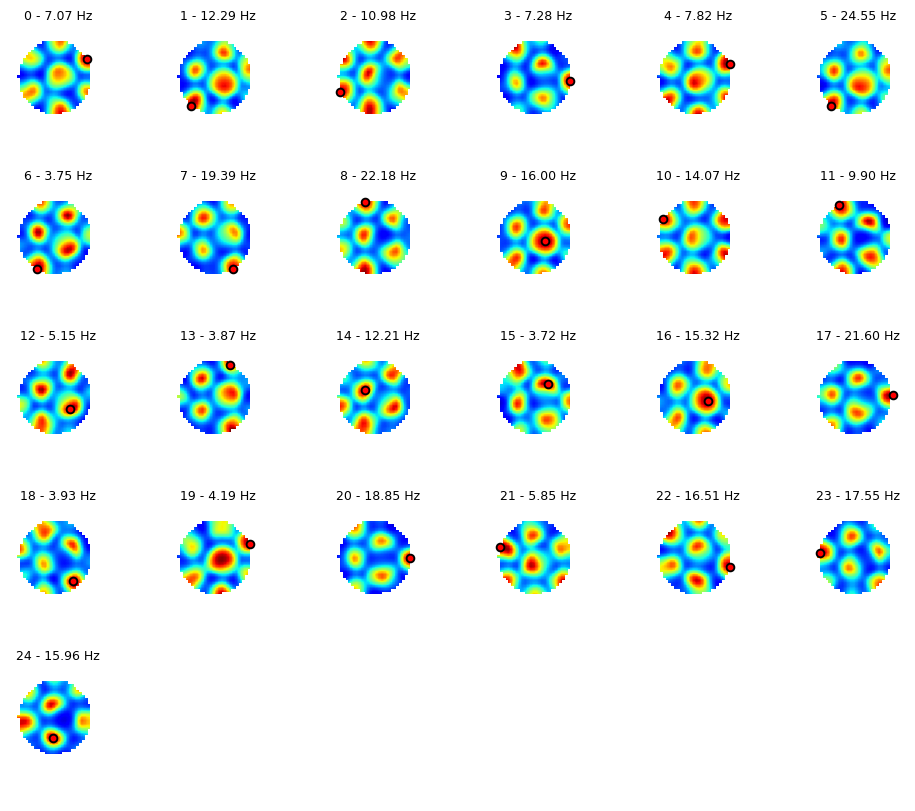

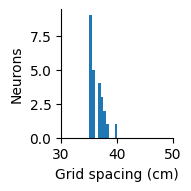

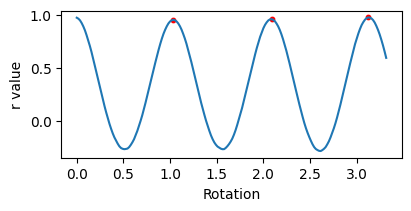

Visualize real and simulated grid pattern before fitting


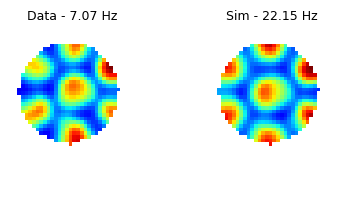

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 46.341084
Improvement of firing rate maps correlation after rigid fitting: from 0.772 to 0.961
Fitting more flexible grid cell model
Loss after flexible model fitting: 46.209312
Improvement of firing rate maps correlation after flexible fitting: from 0.961 to 0.939
Comparison of firing rate maps after fitting different models


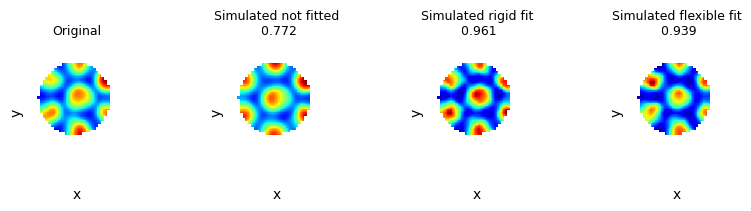

  4%|▍         | 1/25 [01:14<29:37, 74.06s/it]

{'period': array([32.29289874, 32.29289874, 32.29289874]), 'offset': array([-29, -33]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


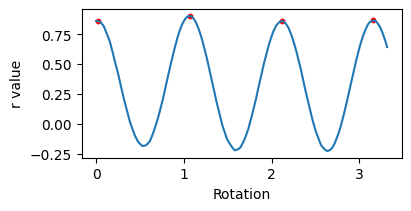

Visualize real and simulated grid pattern before fitting


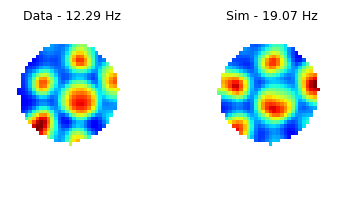

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 84.72053
Improvement of firing rate maps correlation after rigid fitting: from 0.628 to 0.929
Fitting more flexible grid cell model
Loss after flexible model fitting: 84.706635
Improvement of firing rate maps correlation after flexible fitting: from 0.929 to 0.928
Comparison of firing rate maps after fitting different models


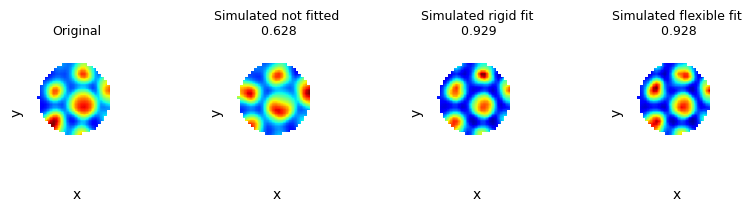

  8%|▊         | 2/25 [02:27<28:09, 73.45s/it]

{'period': array([32.08387445, 32.08387445, 32.08387445]), 'offset': array([-41, -18]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.052569096377712


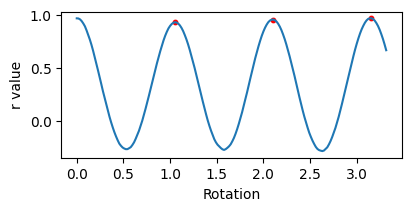

Visualize real and simulated grid pattern before fitting


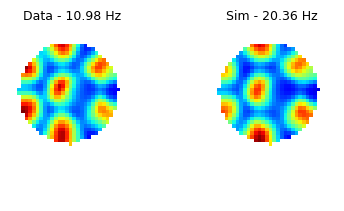

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 67.47313
Improvement of firing rate maps correlation after rigid fitting: from 0.913 to 0.964
Fitting more flexible grid cell model
Loss after flexible model fitting: 67.45298
Improvement of firing rate maps correlation after flexible fitting: from 0.964 to 0.959
Comparison of firing rate maps after fitting different models


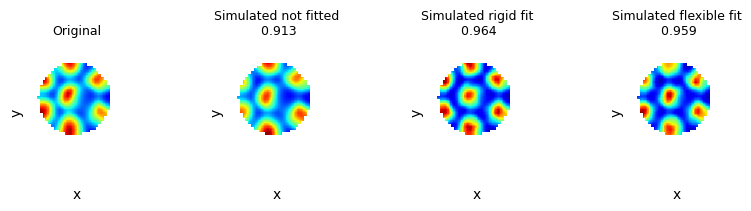

 12%|█▏        | 3/25 [03:39<26:50, 73.19s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([34, -6]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.052569096377712


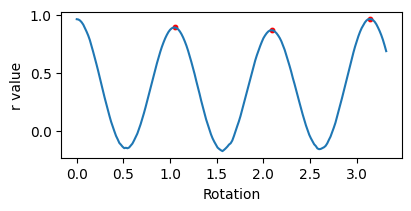

Visualize real and simulated grid pattern before fitting


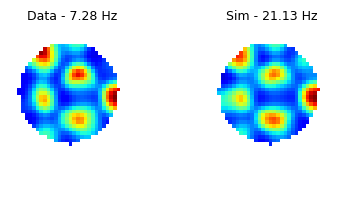

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 35.99473
Improvement of firing rate maps correlation after rigid fitting: from 0.864 to 0.926
Fitting more flexible grid cell model
Loss after flexible model fitting: 35.991653
Improvement of firing rate maps correlation after flexible fitting: from 0.926 to 0.913
Comparison of firing rate maps after fitting different models


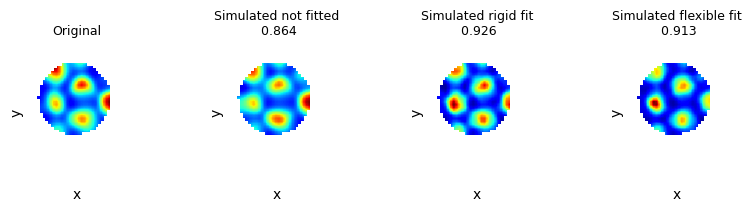

 16%|█▌        | 4/25 [04:53<25:37, 73.21s/it]

{'period': array([32.08387445, 32.08387445, 32.08387445]), 'offset': array([34, 12]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.052569096377712


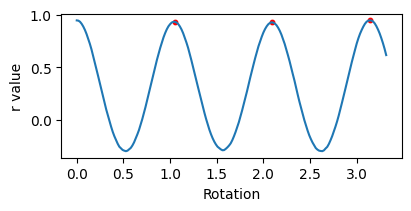

Visualize real and simulated grid pattern before fitting


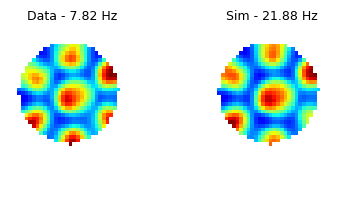

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 56.444187
Improvement of firing rate maps correlation after rigid fitting: from 0.945 to 0.956
Fitting more flexible grid cell model
Loss after flexible model fitting: 56.439686
Improvement of firing rate maps correlation after flexible fitting: from 0.956 to 0.961
Comparison of firing rate maps after fitting different models


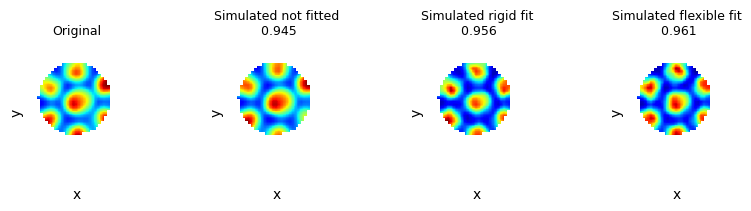

 20%|██        | 5/25 [06:06<24:26, 73.33s/it]

{'period': array([32.08387445, 32.08387445, 32.08387445]), 'offset': array([-29, -33]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


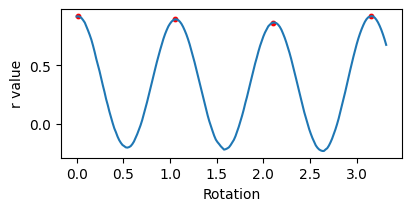

Visualize real and simulated grid pattern before fitting


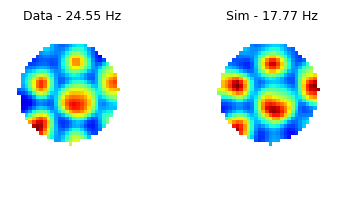

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 170.28156
Improvement of firing rate maps correlation after rigid fitting: from 0.792 to 0.940
Fitting more flexible grid cell model
Loss after flexible model fitting: 170.27483
Improvement of firing rate maps correlation after flexible fitting: from 0.940 to 0.943
Comparison of firing rate maps after fitting different models


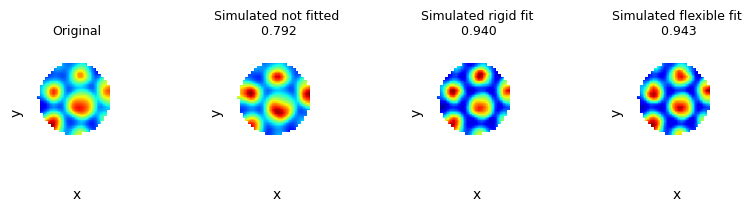

 24%|██▍       | 6/25 [07:19<23:11, 73.23s/it]

{'period': array([30.79569775, 30.79569775, 30.79569775]), 'offset': array([-23, -36]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


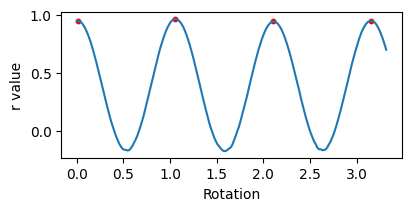

Visualize real and simulated grid pattern before fitting


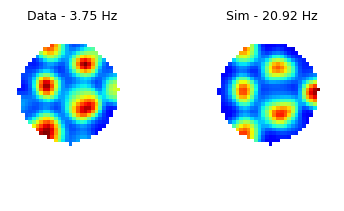

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 23.05332
Improvement of firing rate maps correlation after rigid fitting: from 0.690 to 0.951
Fitting more flexible grid cell model
Loss after flexible model fitting: 23.050653
Improvement of firing rate maps correlation after flexible fitting: from 0.951 to 0.942
Comparison of firing rate maps after fitting different models


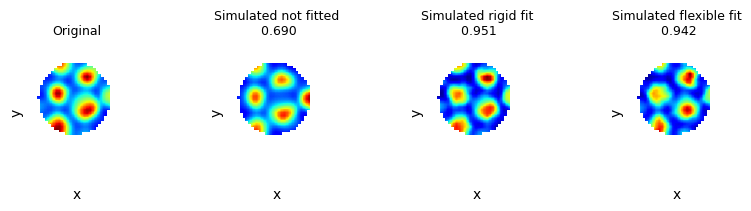

 28%|██▊       | 7/25 [08:32<21:54, 73.04s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([ 16, -36]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.052569096377712


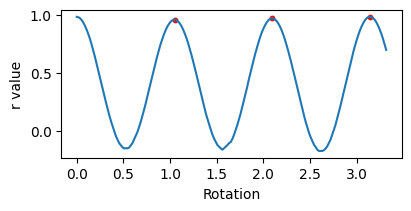

Visualize real and simulated grid pattern before fitting


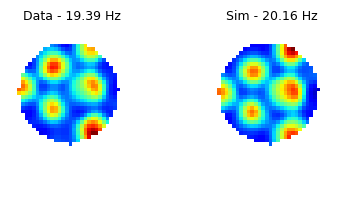

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 97.01491
Improvement of firing rate maps correlation after rigid fitting: from 0.830 to 0.958
Fitting more flexible grid cell model
Loss after flexible model fitting: 96.98452
Improvement of firing rate maps correlation after flexible fitting: from 0.958 to 0.965
Comparison of firing rate maps after fitting different models


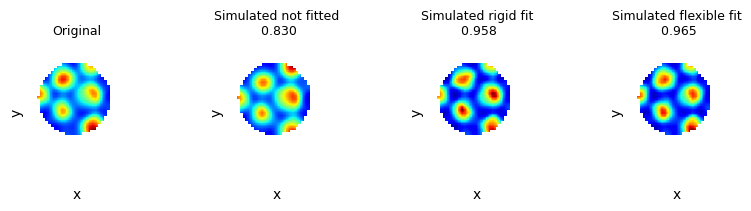

 32%|███▏      | 8/25 [09:45<20:42, 73.08s/it]

{'period': array([30.79569775, 30.79569775, 30.79569775]), 'offset': array([-14,  36]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.052569096377712


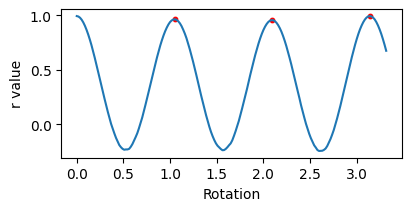

Visualize real and simulated grid pattern before fitting


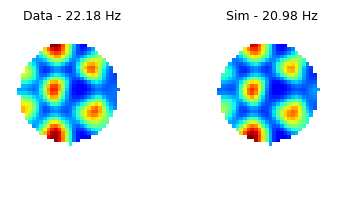

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 119.99142
Improvement of firing rate maps correlation after rigid fitting: from 0.966 to 0.970
Fitting more flexible grid cell model
Loss after flexible model fitting: 119.97501
Improvement of firing rate maps correlation after flexible fitting: from 0.970 to 0.967
Comparison of firing rate maps after fitting different models


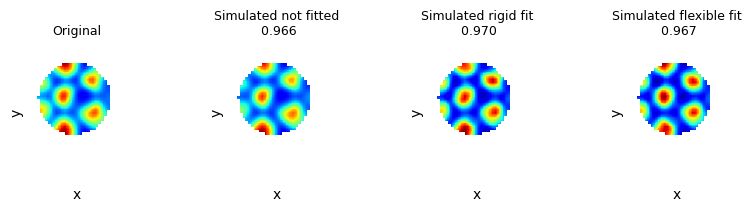

 36%|███▌      | 9/25 [10:58<19:30, 73.13s/it]

{'period': array([32.81051313, 32.81051313, 32.81051313]), 'offset': array([ 7, -6]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.052569096377712


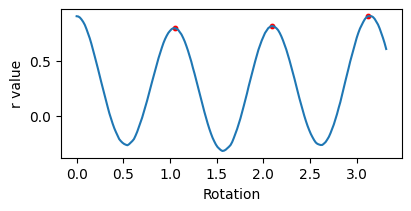

Visualize real and simulated grid pattern before fitting


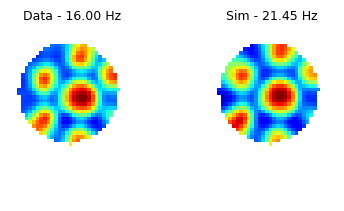

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 116.31941
Improvement of firing rate maps correlation after rigid fitting: from 0.919 to 0.937
Fitting more flexible grid cell model
Loss after flexible model fitting: 116.31394
Improvement of firing rate maps correlation after flexible fitting: from 0.937 to 0.937
Comparison of firing rate maps after fitting different models


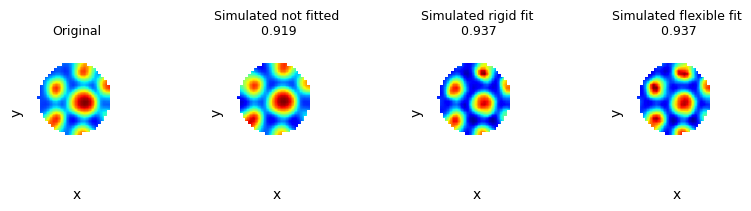

 40%|████      | 10/25 [12:11<18:16, 73.08s/it]

{'period': array([32.29289874, 32.29289874, 32.29289874]), 'offset': array([-38,  18]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.0350262781047501


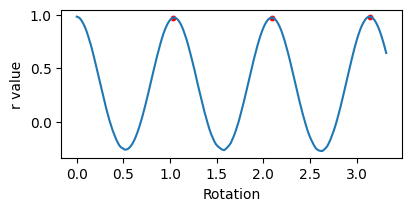

Visualize real and simulated grid pattern before fitting


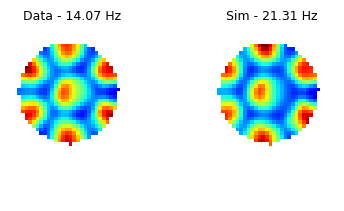

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 93.79448
Improvement of firing rate maps correlation after rigid fitting: from 0.884 to 0.975
Fitting more flexible grid cell model
Loss after flexible model fitting: 93.78212
Improvement of firing rate maps correlation after flexible fitting: from 0.975 to 0.982
Comparison of firing rate maps after fitting different models


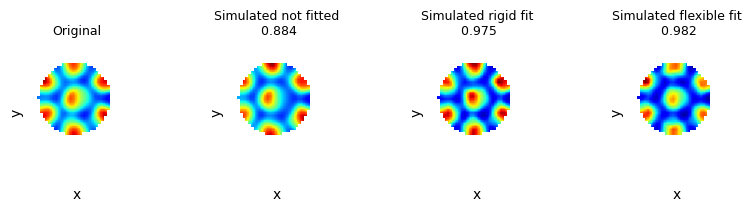

 44%|████▍     | 11/25 [13:24<17:01, 72.98s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([-20,  33]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


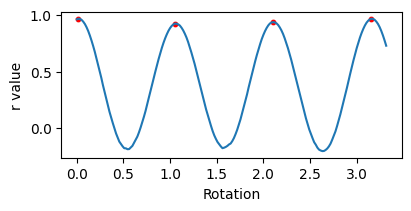

Visualize real and simulated grid pattern before fitting


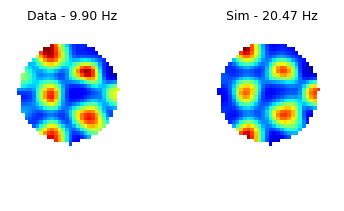

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 52.74262
Improvement of firing rate maps correlation after rigid fitting: from 0.859 to 0.954
Fitting more flexible grid cell model
Loss after flexible model fitting: 52.73979
Improvement of firing rate maps correlation after flexible fitting: from 0.954 to 0.960
Comparison of firing rate maps after fitting different models


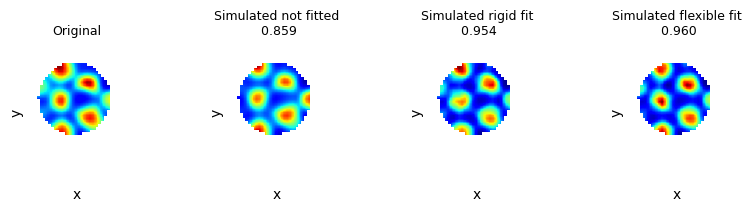

 48%|████▊     | 12/25 [14:37<15:48, 72.98s/it]

{'period': array([30.79569775, 30.79569775, 30.79569775]), 'offset': array([ 13, -15]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.0350262781047501


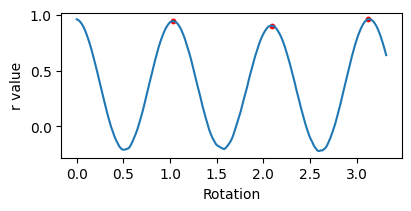

Visualize real and simulated grid pattern before fitting


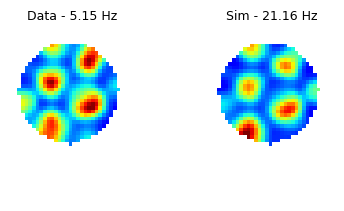

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 31.9571
Improvement of firing rate maps correlation after rigid fitting: from 0.820 to 0.945
Fitting more flexible grid cell model
Loss after flexible model fitting: 31.947075
Improvement of firing rate maps correlation after flexible fitting: from 0.945 to 0.945
Comparison of firing rate maps after fitting different models


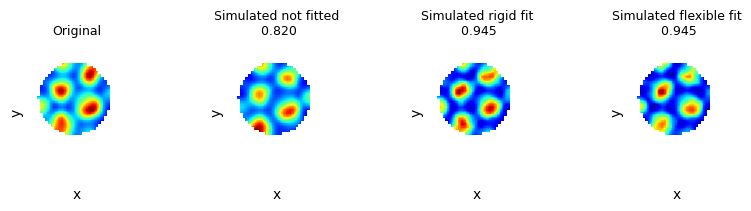

 52%|█████▏    | 13/25 [15:50<14:35, 72.93s/it]

{'period': array([30.79569775, 30.79569775, 30.79569775]), 'offset': array([13, 33]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


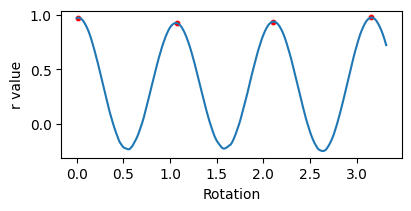

Visualize real and simulated grid pattern before fitting


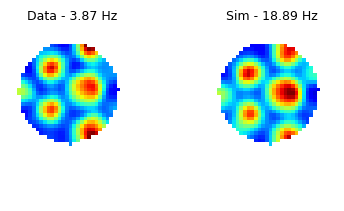

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 22.584698
Improvement of firing rate maps correlation after rigid fitting: from 0.802 to 0.944
Fitting more flexible grid cell model
Loss after flexible model fitting: 22.556686
Improvement of firing rate maps correlation after flexible fitting: from 0.944 to 0.946
Comparison of firing rate maps after fitting different models


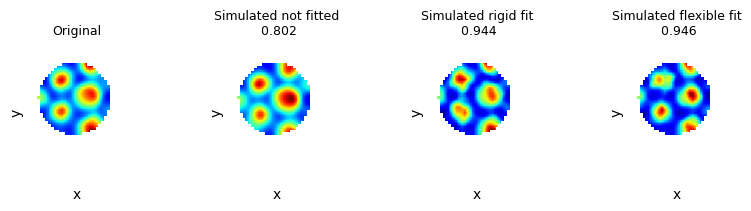

 56%|█████▌    | 14/25 [17:03<13:24, 73.12s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([-14,   6]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.0350262781047501


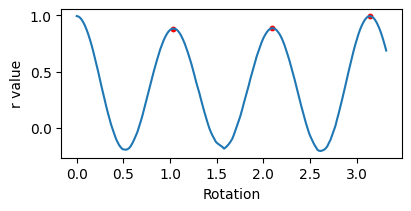

Visualize real and simulated grid pattern before fitting


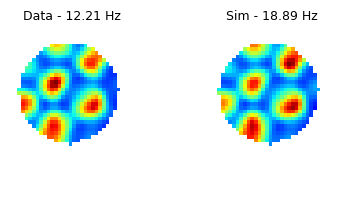

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 71.31137
Improvement of firing rate maps correlation after rigid fitting: from 0.972 to 0.964
Fitting more flexible grid cell model
Loss after flexible model fitting: 71.30838
Improvement of firing rate maps correlation after flexible fitting: from 0.964 to 0.967
Comparison of firing rate maps after fitting different models


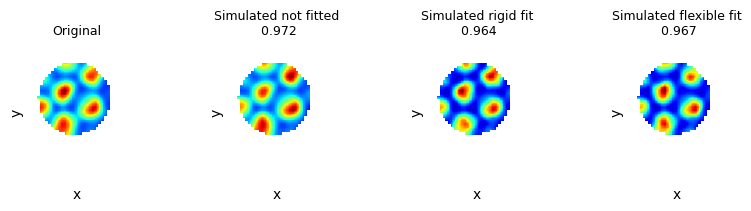

 60%|██████    | 15/25 [18:18<12:16, 73.66s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([10, 12]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


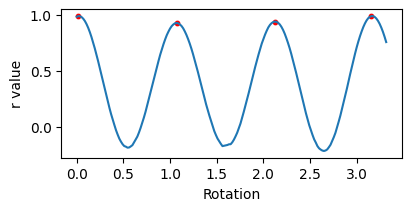

Visualize real and simulated grid pattern before fitting


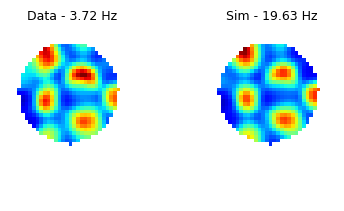

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 20.836773
Improvement of firing rate maps correlation after rigid fitting: from 0.956 to 0.912
Fitting more flexible grid cell model
Loss after flexible model fitting: 20.833935
Improvement of firing rate maps correlation after flexible fitting: from 0.912 to 0.943
Comparison of firing rate maps after fitting different models


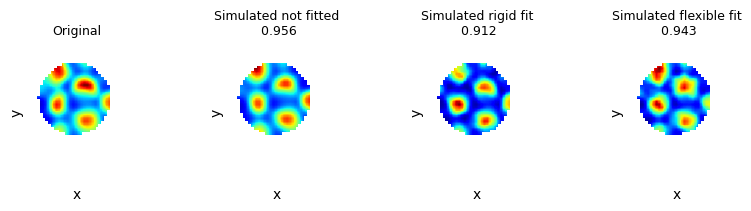

 64%|██████▍   | 16/25 [19:32<11:03, 73.70s/it]

{'period': array([32.81051313, 32.81051313, 32.81051313]), 'offset': array([10, -6]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.0350262781047501


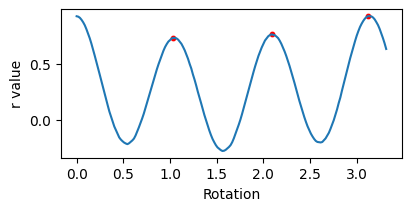

Visualize real and simulated grid pattern before fitting


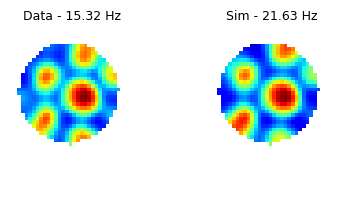

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 107.00369
Improvement of firing rate maps correlation after rigid fitting: from 0.948 to 0.939
Fitting more flexible grid cell model
Loss after flexible model fitting: 106.99933
Improvement of firing rate maps correlation after flexible fitting: from 0.939 to 0.933
Comparison of firing rate maps after fitting different models


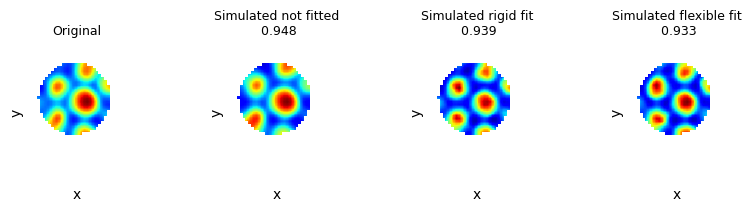

 68%|██████▊   | 17/25 [20:47<09:53, 74.14s/it]

{'period': array([32.08387445, 32.08387445, 32.08387445]), 'offset': array([37,  0]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.0350262781047501


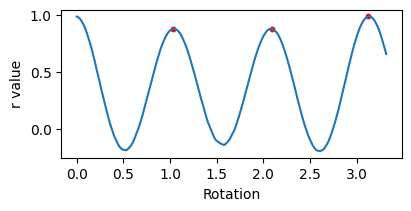

Visualize real and simulated grid pattern before fitting


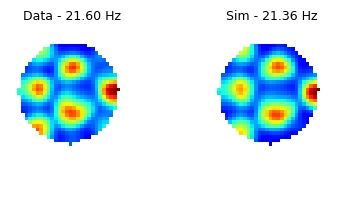

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 115.92078
Improvement of firing rate maps correlation after rigid fitting: from 0.906 to 0.970
Fitting more flexible grid cell model
Loss after flexible model fitting: 115.88866
Improvement of firing rate maps correlation after flexible fitting: from 0.970 to 0.971
Comparison of firing rate maps after fitting different models


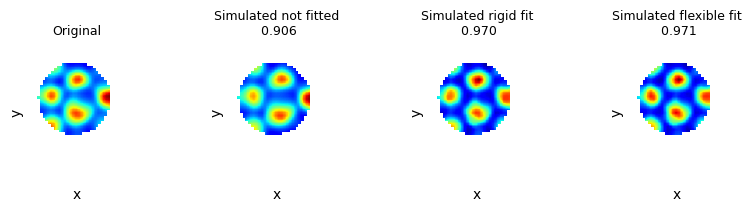

 72%|███████▏  | 18/25 [22:06<08:48, 75.44s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([ 16, -27]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.052569096377712


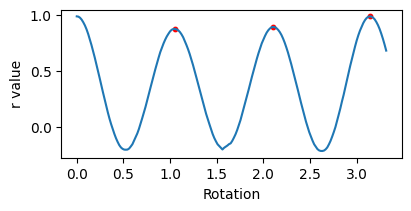

Visualize real and simulated grid pattern before fitting


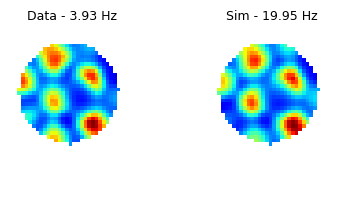

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 19.912876
Improvement of firing rate maps correlation after rigid fitting: from 0.941 to 0.915
Fitting more flexible grid cell model
Loss after flexible model fitting: 19.911455
Improvement of firing rate maps correlation after flexible fitting: from 0.915 to 0.917
Comparison of firing rate maps after fitting different models


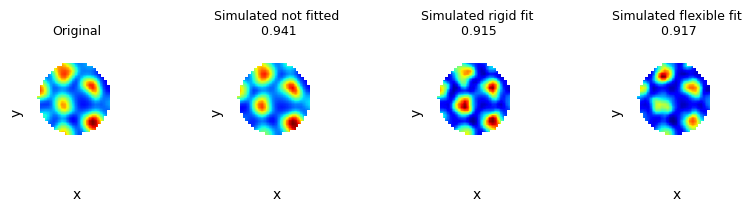

 76%|███████▌  | 19/25 [23:28<07:44, 77.44s/it]

{'period': array([34.70913022, 34.70913022, 34.70913022]), 'offset': array([34, 12]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


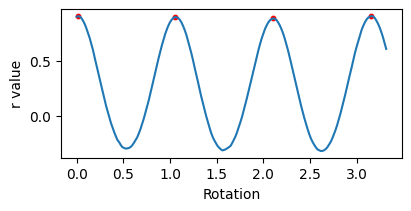

Visualize real and simulated grid pattern before fitting


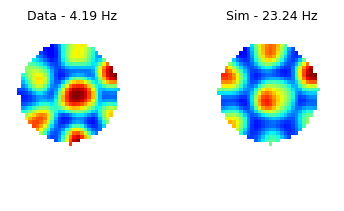

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 34.885185
Improvement of firing rate maps correlation after rigid fitting: from 0.660 to 0.315
Fitting more flexible grid cell model
Loss after flexible model fitting: 32.30677
Improvement of firing rate maps correlation after flexible fitting: from 0.315 to 0.895
Comparison of firing rate maps after fitting different models


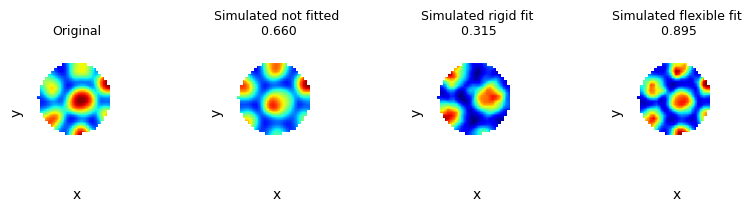

 80%|████████  | 20/25 [24:46<06:28, 77.71s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([34, -3]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.052569096377712


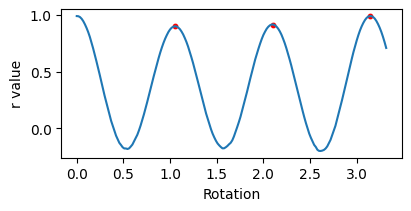

Visualize real and simulated grid pattern before fitting


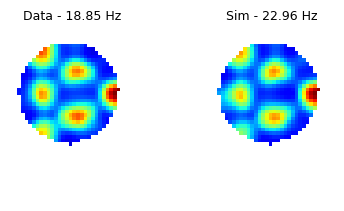

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 92.222565
Improvement of firing rate maps correlation after rigid fitting: from 0.946 to 0.964
Fitting more flexible grid cell model
Loss after flexible model fitting: 92.207085
Improvement of firing rate maps correlation after flexible fitting: from 0.964 to 0.964
Comparison of firing rate maps after fitting different models


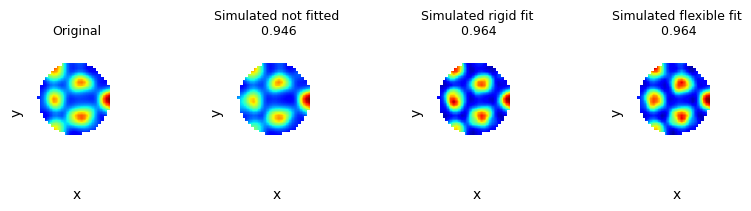

 84%|████████▍ | 21/25 [26:00<05:06, 76.51s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([-41,   9]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.03508563654592373


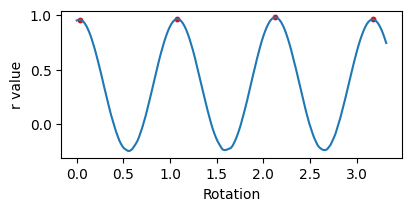

Visualize real and simulated grid pattern before fitting


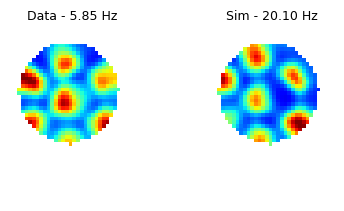

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 38.661266
Improvement of firing rate maps correlation after rigid fitting: from 0.472 to 0.949
Fitting more flexible grid cell model
Loss after flexible model fitting: 38.660824
Improvement of firing rate maps correlation after flexible fitting: from 0.949 to 0.933
Comparison of firing rate maps after fitting different models


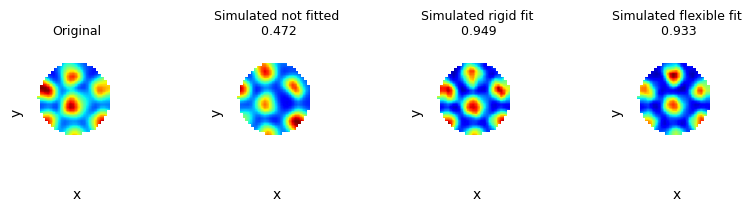

 88%|████████▊ | 22/25 [27:14<03:47, 75.72s/it]

{'period': array([30.79569775, 30.79569775, 30.79569775]), 'offset': array([ 34, -12]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


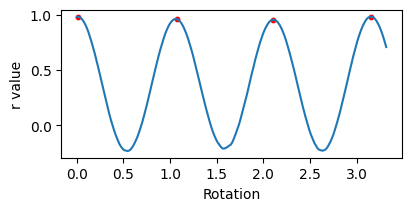

Visualize real and simulated grid pattern before fitting


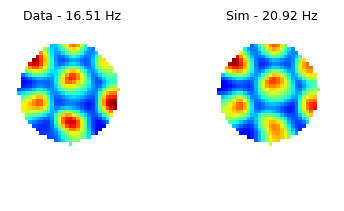

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 101.189926
Improvement of firing rate maps correlation after rigid fitting: from 0.872 to 0.961
Fitting more flexible grid cell model
Loss after flexible model fitting: 101.18237
Improvement of firing rate maps correlation after flexible fitting: from 0.961 to 0.964
Comparison of firing rate maps after fitting different models


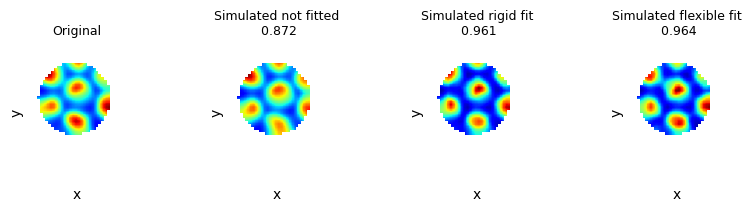

 92%|█████████▏| 23/25 [28:27<02:29, 74.98s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([-41,   3]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.0350262781047501


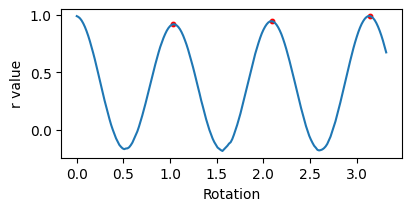

Visualize real and simulated grid pattern before fitting


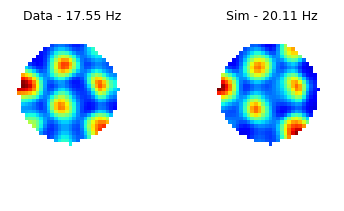

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 84.001366
Improvement of firing rate maps correlation after rigid fitting: from 0.746 to 0.970
Fitting more flexible grid cell model
Loss after flexible model fitting: 84.00009
Improvement of firing rate maps correlation after flexible fitting: from 0.970 to 0.970
Comparison of firing rate maps after fitting different models


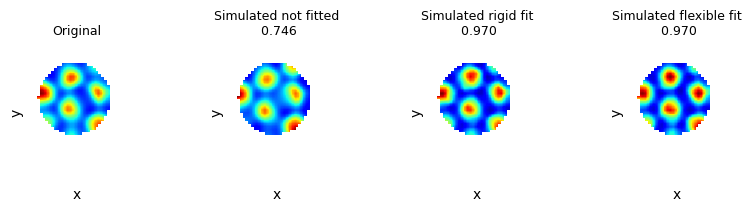

 96%|█████████▌| 24/25 [29:40<01:14, 74.34s/it]

{'period': array([32.29289874, 32.29289874, 32.29289874]), 'offset': array([ -5, -24]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


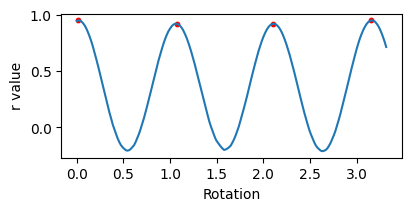

Visualize real and simulated grid pattern before fitting


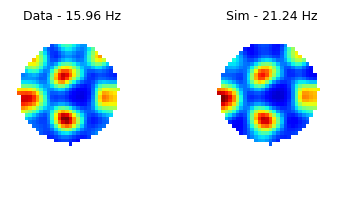

Shape of tensors used for training: torch.Size([87407, 2]) torch.Size([87407, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 76.63254
Improvement of firing rate maps correlation after rigid fitting: from 0.946 to 0.953
Fitting more flexible grid cell model
Loss after flexible model fitting: 76.62544
Improvement of firing rate maps correlation after flexible fitting: from 0.953 to 0.955
Comparison of firing rate maps after fitting different models


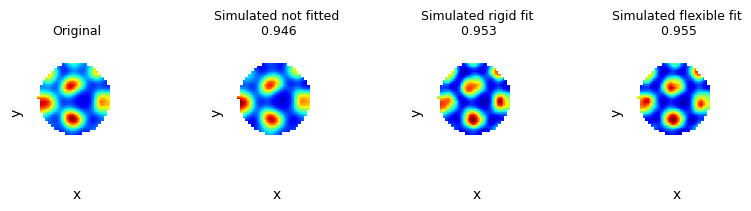

100%|██████████| 25/25 [30:53<00:00, 74.13s/it]

Saving: ../data/grid_cell_parameters.pkl


[{'name': '0',
  'grid_param_initial': {'period': array([33.01308399, 33.01308399, 33.01308399]),
   'offset': array([31, 18]),
   'peak_rate': 25,
   'orientation': array([1.03502628, 2.08759537, 3.12262165])},
  'grid_param_model_rigid': {'period': array([32.034298, 32.034298, 32.034298], dtype=float32),
   'offset': array([34.513115, 20.46831 ], dtype=float32),
   'peak_rate': array([7.4741383], dtype=float32),
   'orientation': array([1.05609727, 2.10329482, 3.15049237])},
  'loss_rigid': array(46.341084, dtype=float32),
  'r_rigid': 0.9605411948233428,
  'grid_param_model_flexible': {'period': array([30.450785, 30.366602, 30.535583], dtype=float32),
   'offset': array([32.695927, 18.730303], dtype=float32),
   'peak_rate': array([7.5755076], dtype=float32),
   'orientation': array([1.0480466, 2.099456 , 3.1527264], dtype=float32)},
  'loss_flexible': array(46.209312, dtype=float32),
  'r_flexible': 0.9390366380924426},
 {'name': '1',
  'grid_param_initial': {'period': array([32.29

In [97]:
find_grid_cell_parameters(neuron_list,save=True)

# Define and run the model

In [98]:
def train_lstm(config,train_grid_coord, train_time, train_ifr, test_grid_coord, test_time,test_ifr, verbose=True):
    """
    This only takes the first 4 columns in train_grid_coord and test_grid_coord (v0, v1)
    """
    
    print(datetime.datetime.now(),config)
    
    train_dataset = NeuralDataset(ifr =train_ifr[:,:config["n_cells"]], pose=train_grid_coord[:,0:4], time=train_time,  seq_length=config["seq_length"])
    ifr_normalization_means = train_dataset.ifr_normalization_means
    ifr_normalization_stds = train_dataset.ifr_normalization_stds
    
    myDict = {"ifr_normalization_means": ifr_normalization_means,
              "ifr_normalization_stds": ifr_normalization_stds}
    
    # fn = sSes.fileBase+".rnn_ifr_normalization.pkl"
    # print("Saving:",fn)
    # with open(fn, 'wb') as handle:
    #     pickle.dump(myDict, handle)
    
    
    test_dataset = NeuralDataset(ifr =test_ifr[:,:config["n_cells"]], 
                             pose=test_grid_coord[:,0:4], 
                                 time= test_time,
                             seq_length=config["seq_length"],
                             ifr_normalization_means=ifr_normalization_means,
                             ifr_normalization_stds=ifr_normalization_stds)
    
    
    
    
    train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=config["batch_size"] , num_workers=2, shuffle=True, pin_memory=True) # to load batches
    test_data_loader = torch.utils.data.DataLoader(test_dataset,batch_size=config["batch_size"] , num_workers=2, shuffle=False, pin_memory=False) # to load batches

    device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    model = LSTM(config["n_cells"], config["hidden_size"], config["num_layers"], config["num_outputs"],config["seq_length"],device=device).to(device)

    


    
    optimizer = torch.optim.SGD(model.parameters(),lr=config["learning_rate"])
    loss_fn = torch.nn.MSELoss() # 

    model.train()

    best_loss = float('inf')  # Initialize with a large value
    best_model_state = None

    df,best_model_state = training_loop(n_epochs=config["num_epochs"],
                 optimizer=optimizer,
                 model = model,
                 loss_fn = loss_fn,
                 train_data_loader=train_data_loader,
                 test_data_loader=test_data_loader,
                 config=config,
                 device = device,
                 verbose=True)
    return df, model,best_model_state

In [99]:
train_ifr,train_pose, train_grid_coord, test_ifr, test_pose, test_grid_coord, grid_param, train_time, test_time = load_position_ifr_dataset()

train_ifr.shape: (87407, 25)
train_pose.shape: (87407, 4)


In [100]:
# HYPERPARAMETERS
config = {"seq_length":20,
            "n_cells":train_ifr.shape[1],
            "hidden_size" :256,
            "num_layers" : 2,
            "num_outputs" : 4, # sin and cos of v0 and v1
            "learning_rate" : 0.01,
            "batch_size" :64,
            "num_epochs": 100}

In [101]:
df, model,best_model_state = train_lstm(config,
                                train_grid_coord,train_time,train_ifr,
                                test_grid_coord,test_time, test_ifr)

2024-03-28 13:17:13.053397 {'seq_length': 20, 'n_cells': 25, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 4, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 100}
Training starting at 2024-03-28 13:17:13.089988


Test loss without training: 0.49869567062366105
2024-03-28 13:17:23.153426 Epoch: 1/100, Training loss: 0.20307535660694495, Testing loss: 0.12608236664624914
2024-03-28 13:17:28.961973 Epoch: 2/100, Training loss: 0.12261274510975463, Testing loss: 0.11807581936678341
2024-03-28 13:17:34.874603 Epoch: 3/100, Training loss: 0.11643629521131516, Testing loss: 0.11394299149246959
2024-03-28 13:17:40.639110 Epoch: 4/100, Training loss: 0.11286774105331035, Testing loss: 0.11134656337324196
2024-03-28 13:17:46.445769 Epoch: 5/100, Training loss: 0.11000234715498733, Testing loss: 0.10918546557823165
2024-03-28 13:17:52.249373 Epoch: 6/100, Training loss: 0.1074383747634392, Testing loss: 0.10693566329277275
2024-03-28 13:17:58.073861 Epoch: 7/100, Training loss: 0.10503328399048194, Testing loss: 0.10484148215918233
2024-03-28 13:18:03.838967 Epoch: 8/100, Training loss: 0.10267357984189582, Testing loss: 0.10310483890579487
2024-03-28 13:18:09.730859 Epoch: 9/100, Training loss: 0.1003398

In [103]:
fn = "../data/grid_cell_model.pt"
print("saving the model state_dict to",fn)
torch.save(best_model_state, fn)

saving the model state_dict to ../data/grid_cell_model.pt
